In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielaalejandrag","key":"ab30bfb971d433be711891a55e8c5938"}'}

In [ ]:
import os
# Create the .kaggle directory and move the kaggle.json file there
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

# Set the environment variable for the Kaggle API
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"


In [ ]:
!pip install kaggle


In [ ]:
!kaggle datasets download -d cynthiarempel/amazon-us-customer-reviews-dataset


Dataset URL: https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset
License(s): other
100% 20.9G/21.0G [03:58<00:00, 132MB/s]
100% 21.0G/21.0G [03:58<00:00, 94.4MB/s]


In [ ]:
#unzipping the files
!unzip amazon-us-customer-reviews-dataset.zip


Archive:  amazon-us-customer-reviews-dataset.zip
  inflating: amazon_reviews_multilingual_US_v1_00.tsv  
  inflating: amazon_reviews_us_Apparel_v1_00.tsv  
  inflating: amazon_reviews_us_Automotive_v1_00.tsv  
  inflating: amazon_reviews_us_Baby_v1_00.tsv  
  inflating: amazon_reviews_us_Beauty_v1_00.tsv  
  inflating: amazon_reviews_us_Books_v1_02.tsv  
  inflating: amazon_reviews_us_Camera_v1_00.tsv  
  inflating: amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv  
  inflating: amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv  
  inflating: amazon_reviews_us_Digital_Software_v1_00.tsv  
  inflating: amazon_reviews_us_Digital_Video_Download_v1_00.tsv  
  inflating: amazon_reviews_us_Digital_Video_Games_v1_00.tsv  
  inflating: amazon_reviews_us_Electronics_v1_00.tsv  
  inflating: amazon_reviews_us_Furniture_v1_00.tsv  
  inflating: amazon_reviews_us_Gift_Card_v1_00.tsv  
  inflating: amazon_reviews_us_Grocery_v1_00.tsv  
  inflating: amazon_reviews_us_Health_Personal_Care_v1_00.ts

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName('amazon_reviews').getOrCreate()

# Load the main file (with .tsv extension and tab delimiter)
df = spark.read.option("delimiter", "\t").csv('amazon_reviews_multilingual_US_v1_00.tsv', header=True, inferSchema=True)

# Show the schema and a few rows of the data
df.printSchema()
df.show(5)


root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_ratin

In [ ]:
# Sentiment analysis

from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import col, lower, when, count, when

# iNITIALIZING Spark session and loading the file
spark = SparkSession.builder.appName('amazon_reviews').getOrCreate()
df = spark.read.option("delimiter", "\t").csv('amazon_reviews_multilingual_US_v1_00.tsv', header=True, inferSchema=True)

# Checking null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Chekcing if review_body have empty values
df.filter(col('review_body').rlike('^\s*$')).show(5)
df_cleaned = df.dropna(subset=['review_body'])

# Deleting empty
df_cleaned = df_cleaned.filter(col('review_body').rlike('^\s*$') == False)


#Text Processsing
# lowercase conversion
df_cleaned = df_cleaned.withColumn('review_body_lower', lower(col('review_body')))

# Tokenization
tokenizer = Tokenizer(inputCol='review_body_lower', outputCol='words')
df_tokens = tokenizer.transform(df_cleaned)

# Deleting stop words
remover = StopWordsRemover(inputCol='words', outputCol='cleaned_words')
df_cleaned = remover.transform(df_tokens)

# Checking null values
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

# Filtering positive and negative values
df_positive = df_cleaned.filter(col("star_rating").isin([4, 5]))
df_negative = df_cleaned.filter(col("star_rating").isin([1, 2]))

print(f"Number of positive reviews: {df_positive.count()}")
print(f"Number of negative reviews: {df_negative.count()}")

# Adding 'sentiment' column
df_sentiment = df_cleaned.withColumn(
    'sentiment',
    when(col('star_rating').isin([4, 5]), 'positive')
    .when(col('star_rating').isin([1, 2]), 'negative')
    .otherwise('neutral')
)

df_sentiment.select('review_body', 'star_rating', 'sentiment').show(5)

# Tokenizer the body_review
tokenizer = Tokenizer(inputCol="review_body_lower", outputCol="new_words")
df_tokens = tokenizer.transform(df_cleaned)
df_tokens.select("review_body_lower", "new_words").show(5)


+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+
|marketplace|customer_id|review_id|product_id|product_parent|product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline|review_body|review_date|
+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+
|          0|          0|        0|         0|             0|            0|               1|          1|            1|          1|   1|                1|             12|        572|        613|
+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+

+-----------+-----------+----

In [ ]:
from pyspark.sql import functions as F

# Total reviews per product category
df_totals = df_grouped.groupBy("product_category").agg(F.sum("count").alias("total_reviews"))

df_percentage = df_grouped.join(df_totals, on="product_category")

# Computing the percentage of reviews per sentiment (positive/negative)
df_percentage = df_percentage.withColumn(
    "percentage",
    (col("count") / col("total_reviews")) * 100
)

df_percentage.show()


+--------------------+---------+------+-------------+------------------+
|    product_category|sentiment| count|total_reviews|        percentage|
+--------------------+---------+------+-------------+------------------+
|  Home Entertainment|  neutral|  3615|        36522|  9.89814358468868|
|               Tools| positive|  6302|         7510| 83.91478029294275|
|           Video DVD|  neutral| 72836|      1096788| 6.640845815235032|
|                Toys| positive| 49618|        57767| 85.89333010196133|
|         Video Games| positive| 12185|        15473| 78.75008078588509|
|               Video| positive| 37407|        46715| 80.07492240179815|
|               Video|  neutral|  3603|        46715| 7.712726105105426|
|         Video Games| negative|  2275|        15473|14.703031086408583|
|               Books| negative| 89937|       838729| 10.72301065063924|
|               Books| positive|685089|       838729| 81.68180663837784|
|               Music|  neutral| 50739|       77864

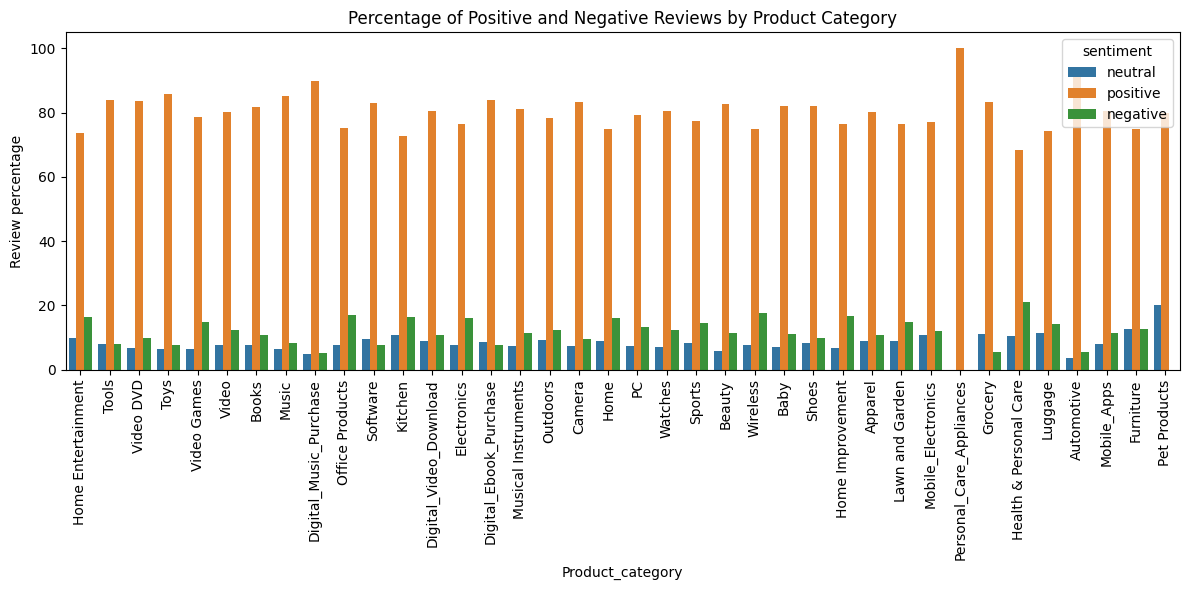

In [ ]:
# Convert to Pandas to do the visualization
df_percentage_pd = df_percentage.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of the category, percentages and sentiment
plt.figure(figsize=(12, 6))
sns.barplot(data=df_percentage_pd, x="product_category", y="percentage", hue="sentiment")
plt.xticks(rotation=90)
plt.title('Percentage of Positive and Negative Reviews by Product Category')
plt.xlabel('Product_category')
plt.ylabel('Review percentage')
plt.tight_layout()
plt.show()
